In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Input,Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.activations import sigmoid, relu, leaky_relu, softmax
from keras.optimizers import Adam
from keras.regularizers import L1, L2
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.losses import sparse_categorical_crossentropy
from keras.metrics import Accuracy

import cv2
import joblib
import tensorflow_datasets

In [2]:
import tensorflow_datasets as tfds

In [3]:
dataset, info = tfds.load(name='fashion_mnist', with_info=True, as_supervised=True)

### Information about the Dataset

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='C:\\Users\\ARSAMANT\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{D

In [5]:
train = dataset['train']
test = dataset['test']

In [6]:
fashion_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

### Example Image

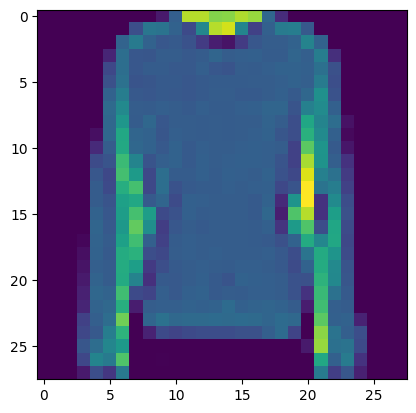

In [7]:
for img, label in train:
    plt.imshow(img)
    break

### Image Preprocessing

In [8]:
def img_preprocessing(dataset, is_fit_transform=False):
    X = []
    Y = []
    for img, label in dataset:
        img = img.numpy()
        label = label.numpy()
        X.append(img)
        Y.append(label)
    
    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)  # Reshape for encoder
    
    if is_fit_transform:
        Y = encoder.fit_transform(Y).toarray()
    else:
        Y = encoder.transform(Y).toarray()
    return X/255.0, Y

In [9]:
encoder = OneHotEncoder()
x,y = img_preprocessing(train, encoder)
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=42)
x_test,y_test = img_preprocessing(test)

In [10]:
print(x.shape)
print(y.shape)

print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000, 10)
(48000, 28, 28, 1)
(48000, 10)
(12000, 28, 28, 1)
(12000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [11]:
label_count = y.shape[1]

### Model Trainning

In [12]:
model = keras.Sequential([
    Input(shape=(28,28,1,)),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(), 
    Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(50, activation='relu', kernel_regularizer=L2(l2=0.001)),
    Dropout(0.2),
    Dense(25, activation='relu', kernel_regularizer=L2(l2=0.001)),
    Dropout(0.2),
    Dense(label_count,activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          57,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,857 (593.19 KB)

 Trainable params: 151,857 (593.19 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### LearningRateScheduler

In [15]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1

In [16]:
History = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=100,
    validation_data=(x_val, y_val),
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
                LearningRateScheduler(scheduler)]
)

Epoch 1/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7045 - loss: 0.9096 - val_accuracy: 0.8353 - val_loss: 0.5249 - learning_rate: 0.0010
Epoch 2/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8374 - loss: 0.5390 - val_accuracy: 0.8735 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 3/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8655 - loss: 0.4554 - val_accuracy: 0.8835 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 4/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8787 - loss: 0.4133 - val_accuracy: 0.8988 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 5/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8880 - loss: 0.3750 - val_accuracy: 0.8992 - val_loss: 0.3348 - learning_rate: 0.0010
Epoch 6/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9078 - loss: 0.3246 - val_accuracy: 0.9036 - val_loss: 0.3161 - learning_rate: 1.0000e-04
Epoch 7/30
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9118

In [17]:
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [18]:
model.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9039 - loss: 0.3217


[0.3216884136199951, 0.9039000272750854]

### Plots

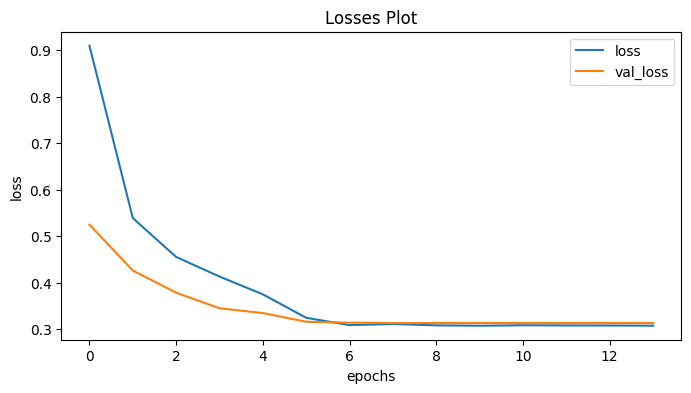

In [19]:
fig=plt.figure(figsize=(8,4))
plt.plot(History.history['loss'], label='loss')
plt.plot(History.history['val_loss'], label='val_loss')
plt.title("Losses Plot")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

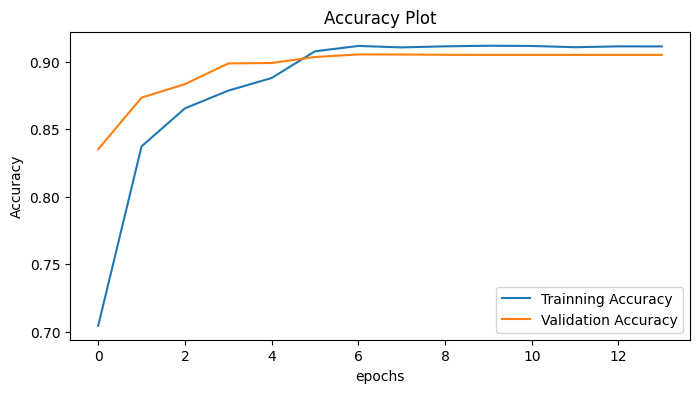

In [20]:
fig=plt.figure(figsize=(8,4))
plt.plot(History.history['accuracy'], label='Trainning Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Plot")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Confusion Matrix

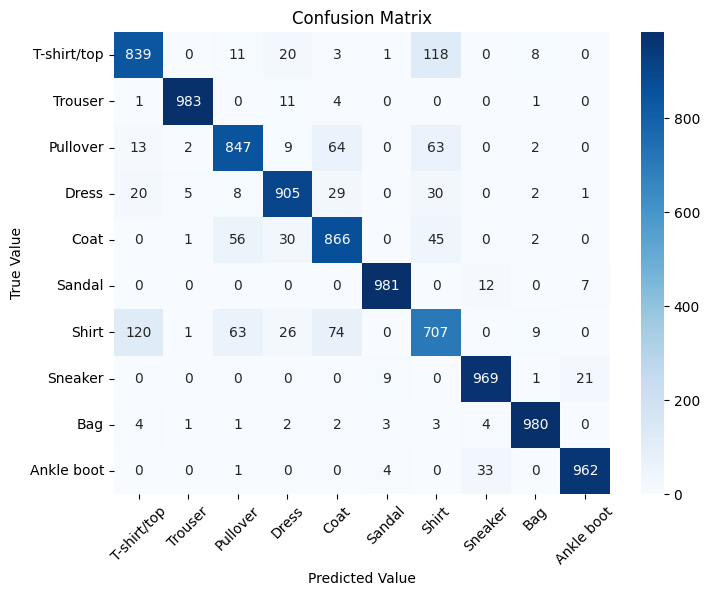

In [21]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

# Class names from your dictionary
class_names = list(fashion_labels.values())

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', fmt='d', annot=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.ylabel('True Value')
plt.xlabel('Predicted Value')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

### Images

In [22]:
def show_classified_images(x_test, y_test, y_pred):
    # Find misclassified indices
    misclassified = np.where(y_test == y_pred)[0]

    # Randomly select 10 misclassified samples
    selected = np.random.choice(misclassified, size=10, replace=False)

    # Plot the misclassified images
    fig=plt.figure(figsize=(8, 4))
    for i, idx in enumerate(selected):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.squeeze(x_test[idx]), cmap='Greens_r')
        plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

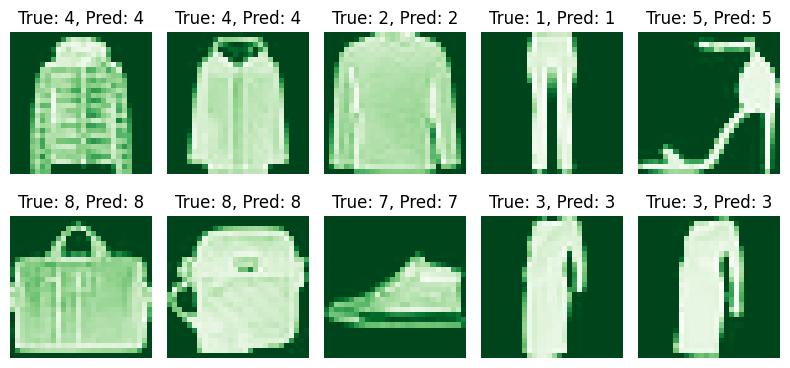

In [23]:
show_classified_images(x_test, y_test_labels, y_pred_labels)

In [24]:
def show_nonclassified_images(x_test, y_test, y_pred):
    # Find misclassified indices
    misclassified = np.where(y_test != y_pred)[0]

    # Randomly select 10 misclassified samples
    selected = np.random.choice(misclassified, size=10, replace=False)

    # Plot the misclassified images
    fig=plt.figure(figsize=(8, 4))
    for i, idx in enumerate(selected):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.squeeze(x_test[idx]), cmap='Reds')
        plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

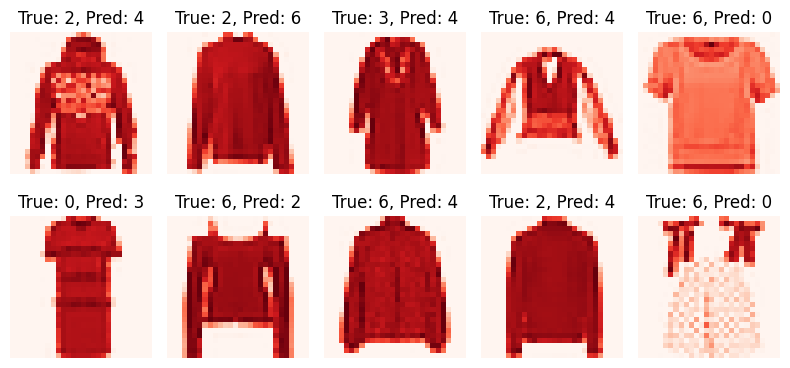

In [25]:
show_nonclassified_images(x_test, y_test_labels, y_pred_labels)

In [26]:
#############################################################################################################################